<div style=float:right><img src="assets/img/applied-logo_100px.png"></img></div>

#### Applied AI Internal Demo Project
## Survival Analysis HDD

Demo some capabilities of parametric and nonparametric survival analysis using Python tools.  
Using hard drive survival data from the [BackBlaze HDD tests](https://www.backblaze.com/blog/hard-drive-data-feb2015/)


# 01_InitialDataPreparation

+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load Data)    
    

+ [Initial Cleaning and Descriptive Analysis](#Initial-Cleaning-and-Descriptive-Analysis)
    1. Reduction: remove disks with >1 row with failure
    2. Reduction: ignore drives that are too small or too big
    3. Correction: properly identify manufacturer
    4. Correction: make capacities human readable
    5. Reduction: Remove under-represented manufacturer-capacities


+ [Specific Cleaning for Survival Durations](#Specific-Cleaning-for-Survival-Durations)
    1. Feature Engineering: de-rez dates to month-year
    2. Feature Engineering: process an elapsed lifetime from the log dates


+ [Stop! There's a potentially critical limiting factor : truncation and censoring](#Stop!-There's-a-potentially-critical-limiting-factor-:-truncation-and-censoring)


+ [Using the SMART features to estimate disk duration](#Using-the-SMART-features-to-estimate-disk-duration)



# Setup

In [1]:
## Interactive magics - comment out if running from another script
%matplotlib inline
%qtconsole --colors=linux --ConsoleWidget.font_size=12 --ConsoleWidget.font_family='Consolas'

In [2]:
from __future__ import division, print_function
from collections import OrderedDict
import re
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cross_validation import StratifiedShuffleSplit
import triangle

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set default styles for plotting via pandas, seaborn and matplotlib
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
sns.set(style='darkgrid')
cmap_clrbld = ['#777777','#E69F00','#56B4E9','#D3C511'
               ,'#009E73','#8D42F0','#0072B2','#D55E00','#CC79A7']
plt.rcParams['axes.color_cycle'] = cmap_clrbld
plt.rcParams['figure.figsize'] = 16, 3

np.random.seed(0)

## Local Functions

In [3]:
## None required here

## Load Data

**NOTE:** Assume that the statements in `data/docs/sql_readme` have been followed and we have a basic database in `data/`

In [4]:
cnx = sqlite3.connect('data/drive_stats.db')
csr = cnx.cursor()

##### Load data from our custom table, setting index and parsing dates correctly

In [5]:
df = pd.read_sql('select * from drive_survival', con=cnx
                 ,index_col='diskid', parse_dates=['mindate','maxdate'])

In [6]:
print(df.shape)
df.head()

(49112, 8)


,model,capacitybytes,mindate,maxdate,nrecords,minhours,maxhours,failed
diskid,,,,,,,,
13H2B97AS,TOSHIBA DT01ACA300,3000592982016,2013-10-15,2014-10-03,354,1349,9816,0
13H3012AS,TOSHIBA DT01ACA300,3000592982016,2013-10-15,2014-09-08,329,1256,9122,0
13H32WEAS,TOSHIBA DT01ACA300,3000592982016,2013-04-26,2014-12-31,558,8,14741,0
13H6A0DGS,TOSHIBA DT01ACA300,3000592982016,2013-04-20,2014-09-02,444,13,12006,0
13H6A21GS,TOSHIBA DT01ACA300,3000592982016,2013-05-22,2014-12-31,532,14,14108,0


In [7]:
df.dtypes

model                    object
capacitybytes             int64
mindate          datetime64[ns]
maxdate          datetime64[ns]
nrecords                  int64
minhours                 object
maxhours                 object
failed                    int64
dtype: object

**Observe:** something's odd with maxhours and minhours, they appear to contain nans.

> Correct for this later

---

---

# Initial Cleaning and Descriptive Analysis

Observe distributions for static data, missing values etc and take corrections accordingly

## 1. Reduction: remove disks with >1 row with failure

In [8]:
df.groupby('failed').size()

failed
0         46182
1          2920
2             4
3             6
dtype: int64

**Observe:** There's 10 harddrives listed as failing more than once. We can use this for survival analysis (which assumes that once the failure occurs, it cannot reoccur).

##### Quick look in DB - anything we can learn?

In [9]:
## view offending rows
df.loc[df['failed'] >=2].head()

,model,capacitybytes,mindate,maxdate,nrecords,minhours,maxhours,failed
diskid,,,,,,,,
S1F013DY,ST3000DM001,3000592982016,2013-04-10,2014-10-01,295,9780,18277,3
S1F018ZS,ST3000DM001,3000592982016,2013-04-10,2014-10-01,295,9778,18273,3
S1F01QSC,ST3000DM001,3000592982016,2013-04-10,2014-10-01,295,9768,18266,3
S1F02N2X,ST3000DM001,3000592982016,2013-04-10,2014-10-01,295,9778,18275,3
S1F02PL9,ST3000DM001,3000592982016,2013-04-10,2014-07-17,243,9278,16406,3


In [10]:
## read raw data from db

diskids = '", "'.join(df.loc[df['failed'] >=2].index.values)
diskids = '"' + diskids + '"'
qdf = pd.read_sql("select * from drive_stats where serial_number in ({})".format(diskids), con=cnx)
qdf.shape

(2570, 85)

In [11]:
print(qdf.loc[qdf['failure'] >0].sort(['serial_number','date']).shape)
qdf.loc[qdf['failure'] >0].sort(['serial_number','date']).head()

(26, 85)


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
1458,2013-05-06,S1F013DY,ST3000DM001,3000592982016,1,,165894456,,,,...,,,,,,,,,,
2120,2013-07-18,S1F013DY,ST3000DM001,3000592982016,1,,191156408,,,,...,,,,,,,,,,
1209,2014-10-01,S1F013DY,ST3000DM001,3000592982016,1,117,137089768,,,92,...,,,,,,,,,,
1452,2013-05-06,S1F018ZS,ST3000DM001,3000592982016,1,,25451944,,,,...,,,,,,,,,,
2116,2013-07-18,S1F018ZS,ST3000DM001,3000592982016,1,,14022976,,,,...,,,,,,,,,,


**Observe:** No obvious pattern for these repeatedly failing drives

##### Decision: remove the disks with >1 row of failure, they're complicating the picture

In [12]:
df = df.loc[df['failed'] <=1]
df.shape

(49102, 8)

## 2. Reduction: ignore drives that are too small or too big

In [13]:
df.groupby('capacitybytes').size()

capacitybytes
80026361856             131
160041885696            252
250000000000              1
250059350016            127
320072933376            146
500107862016            392
1000204886016           728
1125281560064             1
1194001036800             1
1500301910016          3106
2000398934016          5259
3000592982016         12384
4000787030016         26254
6001175126016           317
107349320986927104        1
600332565813390450        2
dtype: int64

##### Decision: remove drives below 1.5TB and above 6TB, and remove single instance 1TB drives

In [14]:
df = df.loc[(df['capacitybytes'] < 10e12) & (df['capacitybytes'] > 1500e9)]
print(df.shape)
df.groupby('capacitybytes').size()

(47320, 8)


capacitybytes
1500301910016     3106
2000398934016     5259
3000592982016    12384
4000787030016    26254
6001175126016      317
dtype: int64

## 3. Correction: properly identify manufacturer

We've been supplied with `model` which actually contains both manufacturer and model information. Need to separate:

##### Separate manufacturer name from model column

In [15]:
df['manufacturer'] = df['model'].apply(lambda x: x.split()[0])
df['model'] = df['model'].apply(lambda x: x.split()[1] if len(x.split()) > 1 else x)
df.groupby(['manufacturer','model']).size()

manufacturer  model          
HGST          HDS5C4040ALE630        6
              HDS724040ALE640       42
              HMS5C4040ALE640     7168
              HMS5C4040BLE640     3115
Hitachi       HDS5C3030ALA630     4651
              HDS5C3030BLE630        1
              HDS5C4040ALE630     2719
              HDS722020ALA330     4774
              HDS723020BLA642       11
              HDS723030ALA640     1046
              HDS723030BLE640       10
              HDS724040ALE640        1
SAMSUNG       HD154UI                4
ST1500DL001   ST1500DL001            2
ST1500DL003   ST1500DL003          116
ST1500DM003   ST1500DM003            5
ST2000DL001   ST2000DL001           12
ST2000DL003   ST2000DL003           16
ST2000DM001   ST2000DM001            8
ST2000VN000   ST2000VN000            5
ST3000DM001   ST3000DM001         4697
ST31500341AS  ST31500341AS         787
ST31500541AS  ST31500541AS        2188
ST32000542AS  ST32000542AS         385
ST320005XXXX  ST320005XXXX        

##### Correct for missing Seagate

In [16]:
df['manufacturer'] = df['manufacturer'].apply(lambda x: 'SEAGATE' if x[:2] == 'ST' else x)

##### Merge HGST and Hitachi

As noted in the BackBlaze article, models listed as HGST or Hitachi should be under the same label

In [17]:
df.loc[df['manufacturer'] == 'Hitachi','manufacturer'] = 'HGST'

## 4. Correction: make capacities human readable

In [18]:
df['capacity'] = df['capacitybytes'].apply(lambda x: '{}TB'.format(round(x / 1e12,2)))
df.groupby(['capacity']).size()

capacity
1.5TB        3106
2.0TB        5259
3.0TB       12384
4.0TB       26254
6.0TB         317
dtype: int64

## 5. Reduction: Remove under-represented manufacturer-capacities

We want to make the survival analysis quite general, so if possible, we want to avoid subgroups that are too small

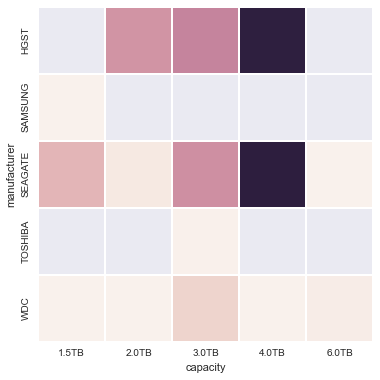

In [19]:
gp = df.groupby(['manufacturer','capacity']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0],robust=True, square=True, cbar=False)

##### Decision: Exclude Samsung and Toshiba

In [20]:
df = df.loc[df['manufacturer'].isin(['HGST','SEAGATE','WDC'])]
df.shape

(47256, 10)

##### View model - capacities

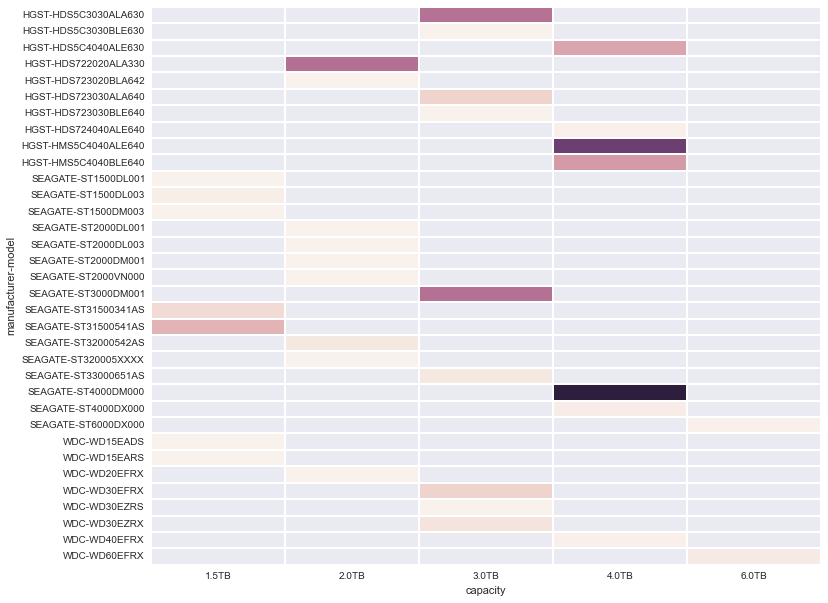

In [21]:
gp = df.groupby(['manufacturer','model','capacity']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,10), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0], robust=True, square=False, cbar=False)

**Observe:** As one might expect, a model only ever appears with a single capacity, so the model-capacity information is mutually redudant.

> For survival analysis we will use only manufacturer and capacity features, ignoring model number which is redundant information

---

---

# Specific Cleaning for Survival Durations

Observe distributions for time-based data and durations - these are critical for survival analysis

## 1. Feature Engineering: de-rez dates to month-year

In [22]:
df['mindateym'] = df['mindate'].apply(lambda x: x.strftime('%Y%m'))
df['maxdateym'] = df['maxdate'].apply(lambda x: x.strftime('%Y%m'))

##### View distribution

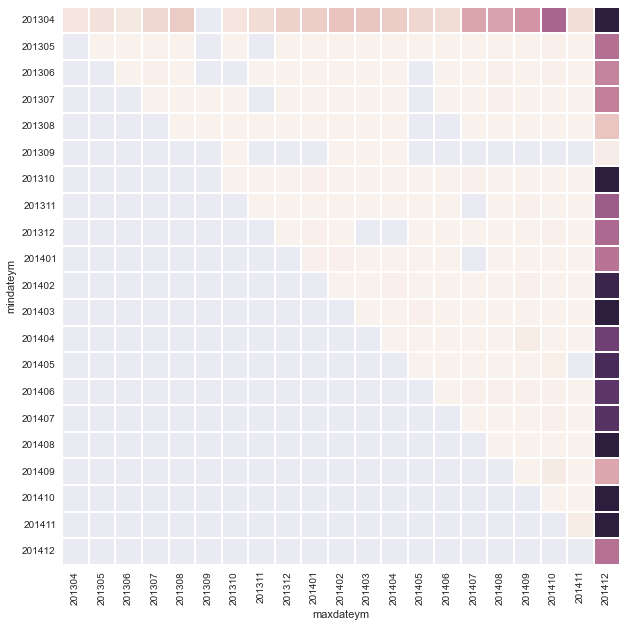

In [23]:
gp = df.groupby(['mindateym','maxdateym']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0],robust=True, square=True, cbar=False)

**Observe:** there's a HUGE number of drives with a final log entry of '201412' at the end of the study.

> We clearly also have some strong right-censoring. This is manageable

**Observe:** there's a HUGE number of drives with an intitial log entry of '201304' at the start of the study.

> Suspect that we have severe left-truncation. We will have to mitigate this somehow

> If we cannot trust the startdate (which is derived from the first date the disk was seen in the logs) then we have massive left-truncation and we don't have a survival duration to work with.

> Maybe there's an alternative?

---

---

# Using the SMART features to estimate disk duration

The column SMART_9_RAW in the original logfiles is apparently a cumulative sum of hours that the drive has been in use since birth

> Perhaps we can use SMART_9_RAW?



**Note:** We preprocessed the min and max smart_9_raw values during the table creation in SQL file `prepare_survival.sql`

## 1. Reduction: remove rows without minhours and maxhours information

In [28]:
print(pd.isnull(df['minhours']).sum())
print(pd.isnull(df['maxhours']).sum())

0
0


In [29]:
print(df.shape[0])
print(df['minhours'].apply(np.isreal).sum())
print(df['maxhours'].apply(np.isreal).sum())

47256
47256
47252


**Observe:** There's 4 rows with non-numeric value for maxhours

> Remove these rows and correct the dtypes

In [30]:
df = df.loc[df['maxhours'].apply(np.isreal)].copy()
df.shape

(47252, 13)

In [31]:
df['minhours'] = df['minhours'].astype(np.int64)
df['maxhours'] = df['maxhours'].astype(np.int64)

In [32]:
df.dtypes

model                    object
capacitybytes             int64
mindate          datetime64[ns]
maxdate          datetime64[ns]
nrecords                  int64
minhours                  int64
maxhours                  int64
failed                    int64
manufacturer             object
capacity                 object
mindateym                object
maxdateym                object
ndaysduration           float64
dtype: object

##### So what do we have?

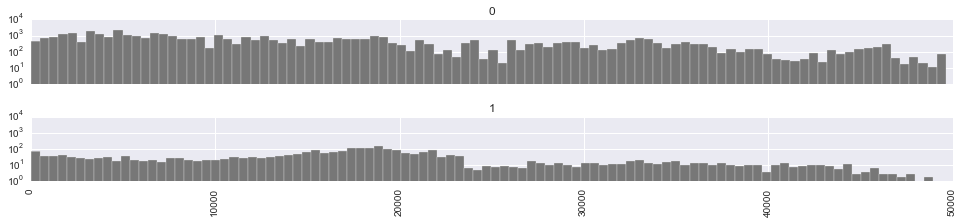

In [33]:
ax=df.hist(column='maxhours', by='failed', bins=100, layout=(2,1), log=True, sharex=True, sharey=True)

**Observe:** The distributions appear reasonable, no readily apparent bunching of disks around particular values of hours

> We will use maxhours for our crucial measure of lifespan

---

---

## Drop unnecessary columns

In [34]:
del df['capacitybytes']

## Final look

In [35]:
print(df.shape)
df.describe()

(47252, 12)


,nrecords,minhours,maxhours,failed,ndaysduration
count,47252.000000,47252.000000,47252.000000,47252.000000,47252.000000
mean,360.801998,5801.483027,15219.486138,0.059765,394.932849
std,194.716471,8612.356718,12036.858647,0.237053,215.027020
min,1.000000,0.000000,4.000000,0.000000,0.000000
25%,181.000000,68.000000,4977.000000,0.000000,200.000000
50%,395.000000,387.000000,12095.000000,0.000000,419.000000
75%,571.000000,9348.000000,22230.000000,0.000000,630.000000
max,630.000000,34704.000000,49641.000000,1.000000,630.000000


## Write back to DB

In [36]:
df.to_sql('drive_survival_prepared', con=cnx, if_exists='replace', index_label='diskid')

---

---
<div style=float:right><img src=assets/img/applied-logo_100px.png></img></div>
**&copy; Applied AI Ltd 2015**  
<a href='http://www.applied.ai'>applied.ai</a>